In [1]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd    #89, 91, 92
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [7]:
dataset=pd.read_csv('nuovo_dataset_totale.csv')

In [8]:
dataset

,Unnamed: 0,id,name,disc_number,duration_ms,explicit,popularity,track_number,artists,album_type,...,valence,tempo,time_signature,tempo_confidence,time_signature_confidence,key_confidence,mode_confidence,n_bars,genre,popularity_artist
0,0,4rjA5kJJWbwU1prXCvg6Fk,Grey,1.0,290.48,False,52.0,5.0,Kölsch,album,...,0.24,186.00,3.0,0.02,1.00,0.50,0.52,234.0,minimal-techno,[51.0]
1,1,6xzpUzzIquIyUzTLbbgSdI,Thrown,1.0,539.23,False,45.0,5.0,Kiasmos,album,...,0.14,120.02,4.0,0.68,0.33,0.41,0.59,269.0,minimal-techno,[47.0]
2,2,56tXgHlSHCfgmGhwVXNizc,Routine,1.0,264.20,False,39.0,5.0,Joris Delacroix,album,...,0.32,118.05,3.0,0.85,0.46,0.90,0.76,171.0,minimal-techno,[44.0]
3,3,0s3wIBczp6TdSJ2y8cveJl,Confronted - Anfisa Letyago Stranger Remix,1.0,387.41,False,0.0,6.0,Pan-Pot;Anfisa Letyago,single,...,0.04,128.99,4.0,0.88,0.50,0.51,0.50,207.0,minimal-techno,"[36.0, 40.0]"
4,4,4PSbDDd1LRYMhqPXvza6I2,Jupiter Sunrise,1.0,248.96,False,0.0,1.0,Kollektiv Turmstrasse,compilation,...,0.12,120.00,4.0,0.88,1.00,0.47,0.46,123.0,minimal-techno,[45.0]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109144,109542,0wiDjWz3U1WfwXSrWHXe2b,I'm Good (Blue) - REAPER Extended Remix,1.0,209.66,True,23.0,2.0,David Guetta;Bebe Rexha;REAPER,single,...,0.37,173.96,4.0,0.73,1.00,0.09,0.18,145.0,edm,"[86.0, 79.0, 50.0]"
109145,109543,46n9OJc7LOIVdj8t2l5WA5,End Of The Night,1.0,205.72,True,56.0,1.0,Danny Avila,single,...,0.31,99.97,4.0,0.71,1.00,0.40,0.54,84.0,edm,[47.0]
109146,109544,127uq83uGFapbddqiMUKky,Sexy Bitch (feat. Akon),1.0,195.85,True,80.0,3.0,David Guetta;Akon,album,...,0.80,130.01,4.0,0.81,0.99,0.10,0.33,106.0,edm,"[86.0, 79.0]"
109147,109545,0ZdUHFxifUJNqo7G4aJzoF,Savannah,1.0,208.70,False,60.0,1.0,Diviners;Philly K.,single,...,0.39,108.07,4.0,0.65,1.00,0.55,0.60,89.0,edm,"[47.0, 38.0]"


In [9]:
import pandas as pd

# Assuming your dataset is in a DataFrame called df

# Define the list of genres
genres_to_filter = ['sertanejo', 'folk', 'j-idol', 'world-music', 'songwriter',
                    'progressive-house', 'heavy-metal', 'mpb', 'opera', 'minimal-techno',
                    'new-age', 'sleep', 'emo', 'kids', 'honky-tonk', 'synth-pop',
                    'goth', 'happy', 'salsa', 'piano']

# Filter the dataset based on the 'genre' column
filtered_df = dataset[dataset['genre'].isin(genres_to_filter)]

# Now, filtered_df contains only the rows where the 'genre' column matches the specified genres


In [10]:
filtered_df

,Unnamed: 0,id,name,disc_number,duration_ms,explicit,popularity,track_number,artists,album_type,...,valence,tempo,time_signature,tempo_confidence,time_signature_confidence,key_confidence,mode_confidence,n_bars,genre,popularity_artist
0,0,4rjA5kJJWbwU1prXCvg6Fk,Grey,1.0,290.48,False,52.0,5.0,Kölsch,album,...,0.24,186.00,3.0,0.02,1.00,0.50,0.52,234.0,minimal-techno,[51.0]
1,1,6xzpUzzIquIyUzTLbbgSdI,Thrown,1.0,539.23,False,45.0,5.0,Kiasmos,album,...,0.14,120.02,4.0,0.68,0.33,0.41,0.59,269.0,minimal-techno,[47.0]
2,2,56tXgHlSHCfgmGhwVXNizc,Routine,1.0,264.20,False,39.0,5.0,Joris Delacroix,album,...,0.32,118.05,3.0,0.85,0.46,0.90,0.76,171.0,minimal-techno,[44.0]
3,3,0s3wIBczp6TdSJ2y8cveJl,Confronted - Anfisa Letyago Stranger Remix,1.0,387.41,False,0.0,6.0,Pan-Pot;Anfisa Letyago,single,...,0.04,128.99,4.0,0.88,0.50,0.51,0.50,207.0,minimal-techno,"[36.0, 40.0]"
4,4,4PSbDDd1LRYMhqPXvza6I2,Jupiter Sunrise,1.0,248.96,False,0.0,1.0,Kollektiv Turmstrasse,compilation,...,0.12,120.00,4.0,0.88,1.00,0.47,0.46,123.0,minimal-techno,[45.0]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99492,99890,2jw9uRjSU1yGjMv3YMhbho,Draw A Crowd,1.0,254.35,False,30.0,6.0,Ben Folds Five,album,...,0.68,112.21,4.0,0.84,1.00,0.43,0.57,117.0,piano,[43.0]
99493,99891,3np71XMsjRnFTol0XTEgOZ,Father in Heaven,2.0,147.63,False,29.0,8.0,Paul Cardall,album,...,0.04,76.49,4.0,0.28,0.11,0.55,0.66,46.0,piano,[48.0]
99494,99892,4VA8Z5k2hd4RkBTlJFPPyd,Baby Lullaby,1.0,188.00,False,30.0,11.0,Piano Peace,album,...,0.14,69.49,5.0,0.26,0.62,0.85,0.87,78.0,piano,[61.0]
99495,99893,7xJEyMvEa3eeP1fN3E18PI,Young Man's Fancy,1.0,231.58,False,19.0,14.0,George Winston,album,...,0.06,76.22,4.0,0.09,0.82,0.31,0.41,67.0,piano,[47.0]


# Preprocessing

In [11]:
filtered_df=filtered_df.drop(['id'], axis=1)
# Assuming df is your original DataFrame with a column named "genre"

y=LabelEncoder().fit_transform(filtered_df["genre"])

# Funzione per trasformare le stringhe in liste di float
def trasforma_in_lista(lst_str):
    # Rimuovi i caratteri '[' e ']' e splitta la stringa
    lst_str = lst_str.strip('][').split(', ')
    # Utilizza eval per valutare la lista di stringhe e convertirla in una lista di float
    return [float(x) for x in lst_str]

# Applica la funzione a ciascun valore nella colonna
filtered_df['popularity_artist'] = filtered_df['popularity_artist'].apply(trasforma_in_lista)

# Calcola la media di ciascuna lista
filtered_df['popularity_artist'] = round(filtered_df['popularity_artist'].apply(np.mean),2)

X=filtered_df.drop(['name', 'Unnamed: 0', 'artists', 'disc_number','album_type', 'album_release_date', 'album_release_date_precision',
       'album_total_tracks', 'album_name', 'genre'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=72)

norm = StandardScaler()
norm.fit(X_train)

X_train_norm = norm.transform(X_train)
X_test_norm = norm.transform(X_test)

# Logistic regression

In [12]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'penalty': ['l1', 'l2'],  # Regularization penalty
    'C': [10, 100],  # Inverse of regularization strength
    'solver': ['liblinear','lbfgs'],  # Optimization algorithm
                                                #in svm abbiamo tenuto linear
    'max_iter': [2000],
    'tol': [0.001, 0.01],
    'dual': [False]
}

# Create logistic regression classifier
logistic_regression = LogisticRegression()

# Perform grid search with cross-validation
grid_search = GridSearchCV(logistic_regression, param_grid, cv=5)  # 5-fold cross-validation
grid_search.fit(X_train_norm, y_train)

# Get the best parameter values
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

In [ ]:
print("Best Score:", grid_search.best_score_)

Best Score: 0.8900652277514434


In [6]:
# Create logistic regression classifier
logistic_regression = LogisticRegression(**best_params)
logistic_regression.fit(X_train_norm, y_train)

LogisticRegression()

In [7]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make predictions on the test set
y_pred = logistic_regression.predict(X_test_norm)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.24241868987631698
Classification Report:
               precision    recall  f1-score   support

           0       0.13      0.11      0.12       205
           1       0.27      0.17      0.21       201
           2       0.04      0.01      0.02       209
           3       0.10      0.05      0.07       204
           4       0.32      0.30      0.31       208
           5       0.03      0.01      0.02       205
           6       0.40      0.47      0.43       202
           7       0.30      0.34      0.32       210
           8       0.00      0.00      0.00       224
           9       0.00      0.00      0.00       201
          10       0.17      0.21      0.19       169
          11       1.00      0.01      0.02       107
          12       0.22      0.15      0.18       182
          13       0.36      0.55      0.44       193
          14       0.26      0.39      0.31       194
          15       0.17      0.21      0.19       197
          16       0.60    

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Obtain predicted probabilities for the positive class (class 1)
y_prob = logistic_regression.predict_proba(X_test_norm)[:, 1]

# Calculate false positive rate (FPR) and true positive rate (TPR)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)


# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve(AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

ValueError: multiclass format is not supported

# MLP (=Neural Network 1+ hid.layers)

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'hidden_layer_sizes': [(100,), (50, 50), (50, 100, 50)],  # Various hidden layer sizes
    'activation': ['logistic', 'tanh', 'relu'],  # Activation functions
    'solver': ['adam', 'sgd'],  # Solvers for optimization
    'alpha': [0.0001, 0.001, 0.01],  # L2 regularization parameter
    'learning_rate': ['constant', 'adaptive'],
    'momentum': [0.1, 0.01, 0.001],
    'n_iter_no_change': [20, 30],
    'early_stopping': [True] # Learning rate schedule
}

# Create MLP classifier
mlp = MLPClassifier()

mlp.fit(X_train_norm, y_train)

# Get the best parameter values
#best_params = grid_search.best_params_
#print("Best Parameters:", best_params)
#print("Best Score:", best_params)

c:\Users\corra\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

In [ ]:
# Make predictions on the test set
y_pred = mlp.predict(X_test_norm)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.9096854562441608
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92      1836
           1       0.90      0.89      0.89      1375

    accuracy                           0.91      3211
   macro avg       0.91      0.91      0.91      3211
weighted avg       0.91      0.91      0.91      3211

Confusion Matrix:
 [[1692  144]
 [ 146 1229]]


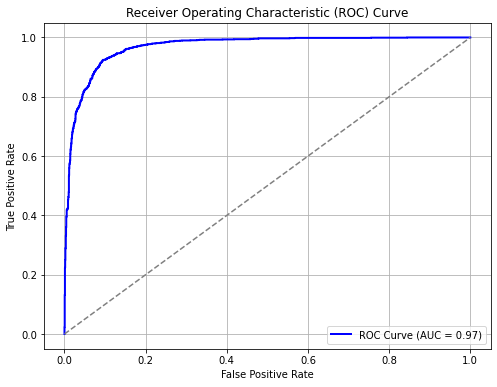

In [ ]:
# Make predictions on the test set
y_prob = mlp.predict_proba(X_test_norm)[:, 1]


# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Ensemble learning

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score

## Random forests

In [ ]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],  # Number of trees in the forest
    'max_depth': [10, 20],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
}

# Create Random Forest classifier
random_forest = RandomForestClassifier(random_state=42)

# Perform grid search with cross-validation (cv=5)
grid_search = GridSearchCV(random_forest, param_grid, cv=5)
grid_search.fit(X_train_norm, y_train)

# Get the best parameter values
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Score: 0.9131113964850501


Accuracy: 0.9230769230769231
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.93      1836
           1       0.91      0.92      0.91      1375

    accuracy                           0.92      3211
   macro avg       0.92      0.92      0.92      3211
weighted avg       0.92      0.92      0.92      3211

Confusion Matrix:
 [[1704  132]
 [ 115 1260]]


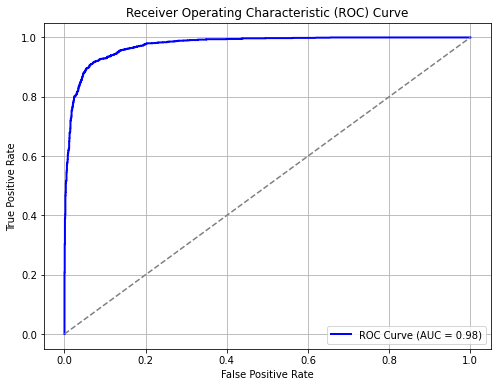

In [ ]:
# Create a Random Forest classifier
random_forest = RandomForestClassifier(**best_params)

# Train the classifier
random_forest.fit(X_train_norm, y_train)

# Make predictions on the test set
y_pred = random_forest.predict(X_test_norm)

# Calculate predicted probabilities for the positive class
y_prob = random_forest.predict_proba(X_test_norm)[:, 1]

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)
auc = roc_auc_score(y_test, y_prob)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

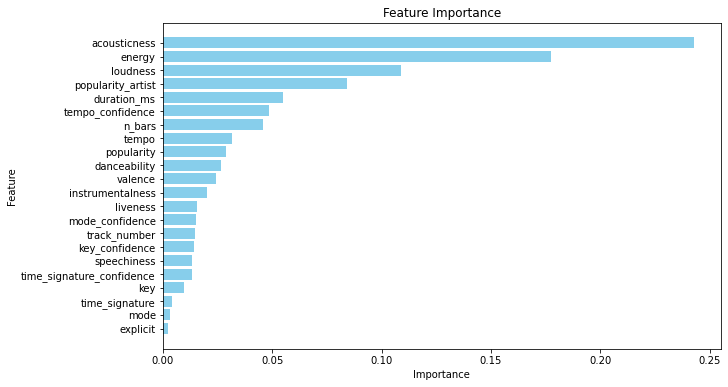

In [ ]:
# Get feature importances
feature_importance = random_forest.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to display features with the highest importance at the top
plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Create the Gradient Boosting Machine model
gbm = GradientBoostingClassifier()

# Define the parameter grid
param_grid = {
    'n_estimators': [200, 300],  # Number of trees
    'max_depth': [5, 7],  # Maximum depth of each tree
    'learning_rate': [0.01, 0.05],  # Learning rate
    'min_samples_split': [5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [3, 5]  # Minimum number of samples required at each leaf node
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=gbm,
                           param_grid=param_grid,
                           cv=5,  # 5-fold cross-validation
                           scoring='accuracy',  # Evaluation metric
                           )  

# Fit the GridSearchCV object to the data
grid_search.fit(X_train_norm, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)


Best Parameters: {'learning_rate': 0.05, 'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 300}
Best Score: 0.9211306871165792


In [ ]:
# Create the Gradient Boosting Machine model
gbm = GradientBoostingClassifier(**best_params)
gbm.fit(X_train_norm, y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=7, min_samples_leaf=5,
                           min_samples_split=5, n_estimators=300)

In [ ]:
# Make predictions on the test set
y_pred = gbm.predict(X_test_norm)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)

In [ ]:
accuracy

0.9280597944565556

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1836
           1       0.91      0.92      0.92      1375

    accuracy                           0.93      3211
   macro avg       0.93      0.93      0.93      3211
weighted avg       0.93      0.93      0.93      3211



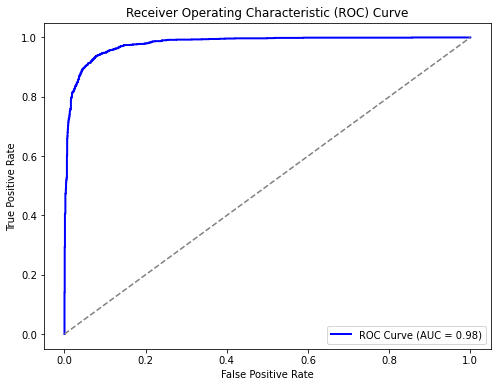

In [ ]:
# Make predictions on the test set
y_pred = gbm.predict(X_test_norm)

# Calculate predicted probabilities for the positive class
y_prob = gbm.predict_proba(X_test_norm)[:, 1]

# Calculate false positive rate (FPR) and true positive rate (TPR)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

# Plot ROC curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Plot feature importance
feature_importance = gbm.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(10, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_test.columns)[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance (Gradient Boosting Machine)')
plt.show()


NameError: name 'gbm' is not defined